In [20]:
# packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [27]:
# read data
df = pd.read_csv('challenge/dataset_SCL.csv', sep = ',')

# transform to datetime format
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

# sample of data
df.head()

/var/folders/nz/9mbks9xs2hv0lybrdkjrk2rh0000gn/T/ipykernel_95041/2466737034.py:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('challenge/dataset_SCL.csv', sep = ',')


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


# 1. ¿How is the data distributed? 

In [32]:
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} features!')

The dataset contains 68206 rows and 18 features!


In [31]:
df['SIGLAORI'].value_counts()

Santiago    68206
Name: SIGLAORI, dtype: int64

The dataset contains only departures from Santiago, not arrivals. Let´s see how those departures are distributed

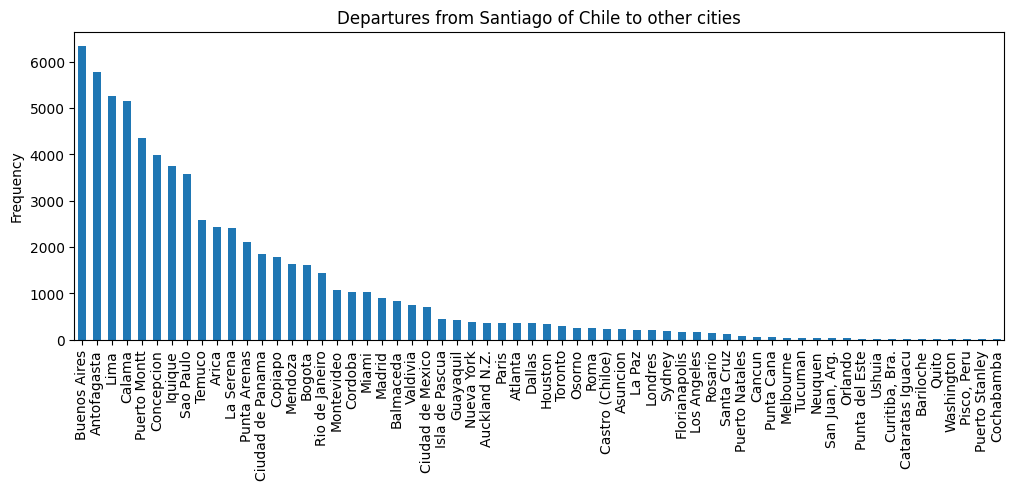

In [38]:
plt.figure(figsize = (12, 4))
df['SIGLADES'].value_counts().plot.bar()
plt.title('Departures from Santiago of Chile to other cities')
plt.ylabel('Frequency')
plt.show()

Apparently, the departures from Santiago are concentrated on destinations within `South America`. On that regard, it is noted that the majority of flights are local, with some expectable exceptions like departures to `Buenos Aires` or `Lima`.

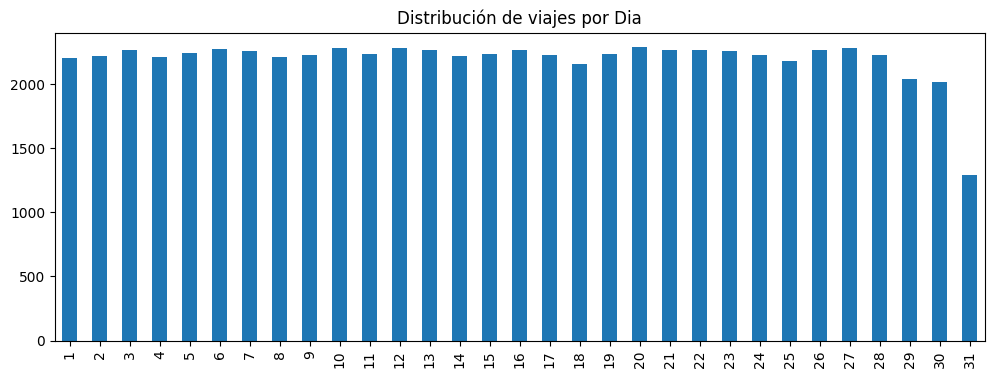

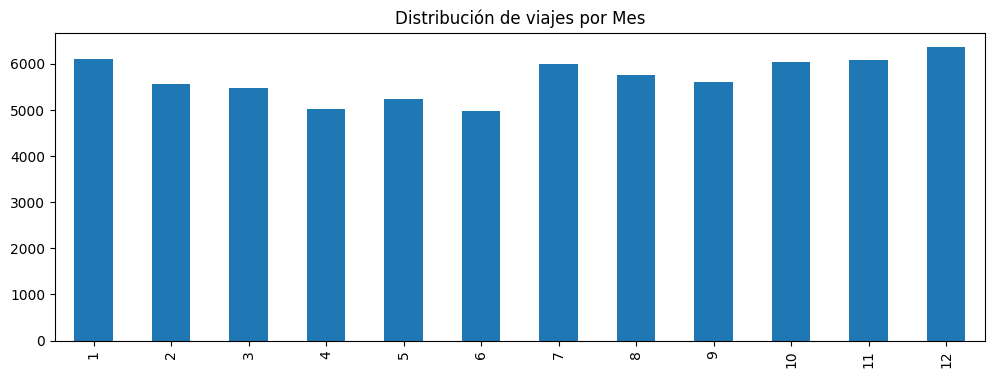

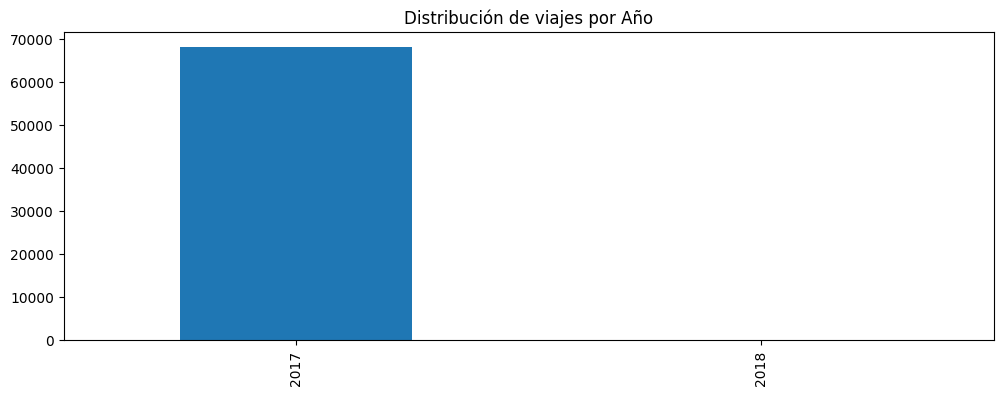

In [60]:
for feature in ['DIA', 'MES', 'AÑO']:
    plt.figure(figsize = (12, 4))
    df[feature].value_counts().sort_index().plot.bar()
    plt.title(f'Distribución de viajes por {feature.title()}')
    plt.show()


Del gráfico anterior, se observa:

- La cantidad de viajes por `DIA` se distribuye de manera relativamente homógenea, con una moderada disminución en los últimos días del mes. Esto puede ser explicado en que los últimos días del mes (29, 30 y 31) no están presentes en todos los meses del año.
- La cantidad de viajes por `MES` se distribuye con leves diferencias entre cada mes, siendo los meses con mayor cantidad de vuelos Diciembre, Enero y Julio.
- La cantidad de viajes por `AÑO` es casi en la totalidad orientada hacia el año 2017, donde tan solo 2 viajes de los 68.206 viajes en el dataset son del año 2018.

In [73]:
df['año_mes'] = df.apply(lambda x: str(x['AÑO']) + '_' + str(x['MES']), axis = 1)
df.groupby('año_mes').count()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
año_mes,,,,,,,,,,,,,,,,,,
2017_1,6106,6106,6106,6106,6106,6106,6105,6106,6106,6106,6106,6106,6106,6106,6106,6106,6106,6106
2017_10,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032
2017_11,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080
2017_12,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356
2017_2,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561
2017_3,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482
2017_4,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020
2017_5,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240
2017_6,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981
